# jaxshearlab

Test case and demonstration of `PyShearLab` working in `jax`. 

In [1]:
# core jax
import jax
from jax import numpy as np

# shearlet transforms
import jaxshearlab as jsl
import pyshearlab as sl

# 64 bit floats
jax.config.update("jax_enable_x64", True)

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl


Loading in a test image.

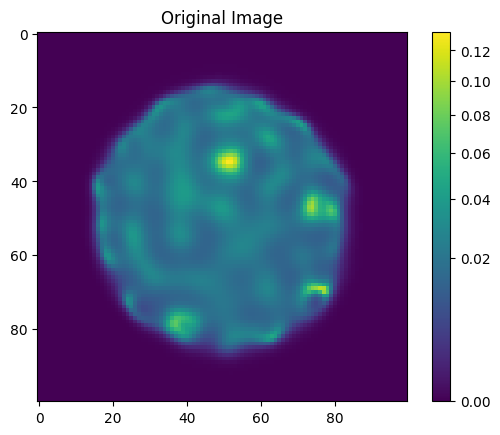

In [2]:
img = np.load("test_img.npy")

plt.figure()
plt.title("Original Image")
plt.imshow(img, norm=mpl.colors.PowerNorm(0.5, vmin=0))
plt.colorbar()
plt.show()


## Shearlet Transform

In [3]:
shearletSystem = jsl.pyShearLab2D.SLgetShearletSystem2D(
    useGPU=0,
    rows=img.shape[0],
    cols=img.shape[1],
    nScales=2,
)

# jitting
@jax.jit
def shearlet_transform(array, shearletSystem=shearletSystem):
    return jsl.pyShearLab2D.SLsheardec2D(array, shearletSystem)


In [12]:
shearlets = shearlet_transform(img)
print(shearlets.shape)

# timing
%timeit shearlet_transform(img)

(100, 100, 17)
1.64 ms ± 27.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Visualising shearlets

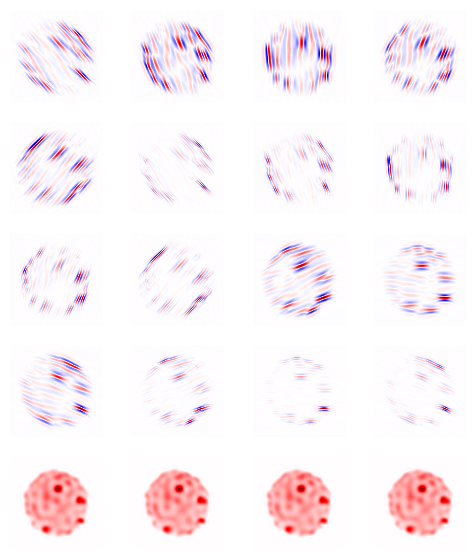

In [5]:
plt.subplots(shearlets.shape[2]//4 + 1, 4, figsize=(6, 7))

for i in range(4 * (shearlets.shape[2]//4 + 1)):
    plt.subplot(shearlets.shape[2]//4 + 1, 4, i + 1)
    plt.axis("off")
    try:
        plt.imshow(
            shearlets[:, :, i],
            "seismic",
            norm=mpl.colors.CenteredNorm(0),
            )
    except:
        continue

plt.show()

## Inverse Shearlet Transform

In [6]:
# jitting
@jax.jit
def shearlet_inv_transform(array, shearletSystem=shearletSystem):
    return jsl.pyShearLab2D.SLshearrec2D(array, shearletSystem)

Performing reconstruction

In [7]:
recon = shearlet_inv_transform(shearlets)
print(recon.shape)

%timeit shearlet_inv_transform(shearlets)

(100, 100)
1.54 ms ± 82.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Observing residuals between reconstruction and original image

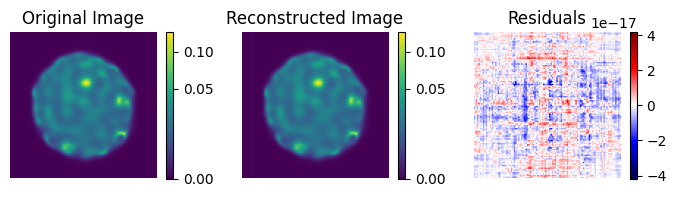

In [8]:
plt.subplots(1, 3, figsize=(7, 2))

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img, "viridis", norm=mpl.colors.PowerNorm(0.5, vmin=0))
plt.title("Original Image")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img, "viridis", norm=mpl.colors.PowerNorm(0.5, vmin=0))
plt.title("Reconstructed Image")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img - recon, cmap='seismic', norm=mpl.colors.CenteredNorm(0))
plt.title("Residuals")
plt.colorbar()

plt.tight_layout()
plt.show()


## Comparing to `pyshearlab`

In [9]:
shearlets_sl = sl.SLsheardec2D(img, shearletSystem)
recon_sl = sl.SLshearrec2D(shearlets_sl, shearletSystem)

In [10]:
# timing comparison

%timeit sl.SLsheardec2D(img, shearletSystem)
%timeit sl.SLshearrec2D(shearlets_sl, shearletSystem)

4.26 ms ± 239 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.3 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


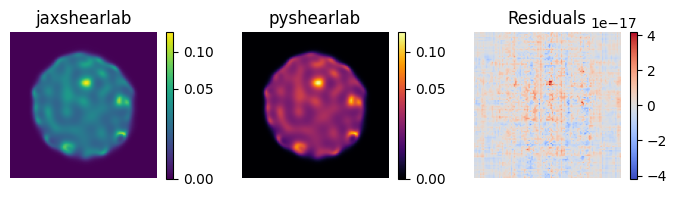

In [11]:
plt.subplots(1, 3, figsize=(7, 2))

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(recon, "viridis", norm=mpl.colors.PowerNorm(0.5, vmin=0))
plt.title("jaxshearlab")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(recon_sl, "inferno", norm=mpl.colors.PowerNorm(0.5, vmin=0))
plt.title("pyshearlab")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(recon - recon_sl, cmap='coolwarm', norm=mpl.colors.CenteredNorm(0))
plt.title("Residuals")
plt.colorbar()

plt.tight_layout()
plt.show()


Matching to machine precision!